In [30]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.mlab as mlab

In [31]:
matplotlib_is_available = True
try:
    from matplotlib import pyplot as plt
except ImportError:
    print("Will skip plotting; matplotlib is not available.")
    matplotlib_is_available = False

In [32]:
# ### Uncomment only one of these to define what data is actually sent to the Discriminator
#(name, preprocess, d_input_func) = ("Raw data", lambda data: data, lambda x: x)
#(name, preprocess, d_input_func) = ("Data and variances", lambda data: decorate_with_diffs(data, 2.0), lambda x: x * 2)
(name, preprocess, d_input_func) = ("Data and diffs", lambda data: decorate_with_diffs(data, 2.0), lambda x: x * 2)
#(name, preprocess, d_input_func) = ("Only 4 moments", lambda data: get_moments(data), lambda x: 4)
print("Using data [%s]" % (name))

Using data [Data and diffs]


## DATA: Target data and generator input data

Functions to generate target Normal disctribution and noise that goes to Generator

In [38]:
# Data params
data_mean = 4
data_stddev = 2

In [39]:
def get_distribution_sampler(mu, sigma):
    return lambda n: torch.Tensor(np.random.normal(mu, sigma, (1, n)))  # Gaussian

def get_generator_input_sampler():
    return lambda m, n: torch.rand(m, n)  # Uniform-dist data into generator, _NOT_ Gaussian

Define other supporting functions

In [40]:
def extract(v):
    return v.data.storage().tolist()

def stats(d):
    return [np.mean(d), np.std(d)]

def get_moments(d):
    # Return the first 4 moments of the data provided
    mean = torch.mean(d)
    diffs = d - mean
    var = torch.mean(torch.pow(diffs, 2.0))
    std = torch.pow(var, 0.5)
    zscores = diffs / std
    skews = torch.mean(torch.pow(zscores, 3.0))
    kurtoses = torch.mean(torch.pow(zscores, 4.0)) - 3.0  # excess kurtosis, should be 0 for Gaussian
    final = torch.cat((mean.reshape(1,), std.reshape(1,), skews.reshape(1,), kurtoses.reshape(1,)))
    return final

def decorate_with_diffs(data, exponent, remove_raw_data=False):
    mean = torch.mean(data.data, 1, keepdim=True)
    mean_broadcast = torch.mul(torch.ones(data.size()), mean.tolist()[0][0])
    diffs = torch.pow(data - Variable(mean_broadcast), exponent)
    if remove_raw_data:
        return torch.cat([diffs], 1)
    else:
        return torch.cat([data, diffs], 1)

## MODELS: Generator model and discriminator model

In [41]:
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.elu(self.map1(x))
        x = F.sigmoid(self.map2(x))
        return self.map3(x)

class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Discriminator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.elu((self.map1(x)))
        x = F.elu((self.map2(x)))
        return self.map3(x) #the discriminant model uses the linear activation function directly instead of the Sigmoid function

## Training process

In [43]:
def train():
    # Model parameters
    g_input_size = 1      # Random noise dimension coming into generator, per output vector
    g_hidden_size = 50    # Generator complexity
    g_output_size = 1     # Size of generated output vector
    
    d_input_size = 100    # Minibatch size - cardinality of distributions
    d_hidden_size = 50    # Discriminator complexity
    d_output_size = 1     # Single dimension for 'real' vs. 'fake' classification
    
    minibatch_size = d_input_size

    d_learning_rate = 2e-4
    g_learning_rate = 2e-4

    num_epochs = 50000
    print_interval = 1000
    #'k' steps in the original GAN paper. Can put the discriminator on higher training freq than generator
    d_steps = 5
    g_steps = 1

    dfe, dre, ge = 0, 0, 0
    d_real_data, d_fake_data, g_fake_data = None, None, None

    d_sampler = get_distribution_sampler(data_mean, data_stddev)
    gi_sampler = get_generator_input_sampler()
    
    G = Generator(input_size=g_input_size,
                  hidden_size=g_hidden_size,
                  output_size=g_output_size)
    
    D = Discriminator(input_size=d_input_func(d_input_size),
                      hidden_size=d_hidden_size,
                      output_size=d_output_size)
    
    d_optimizer = optim.RMSprop(D.parameters(), lr=d_learning_rate)
    g_optimizer = optim.Adam(G.parameters(), lr=g_learning_rate)


    for epoch in range(num_epochs):
        for d_index in range(d_steps):
            # 1. Train D on real+fake
            D.zero_grad()

            #  1A: Train D on real
            d_real_data = Variable(d_sampler(d_input_size))
            d_real_decision = D(preprocess(d_real_data))
            d_real_error = -torch.mean(d_real_decision)
            d_real_error.backward() # compute/store gradients, but don't change params

            #  1B: Train D on fake
            d_gen_input = Variable(gi_sampler(minibatch_size, g_input_size))
            d_fake_data = G(d_gen_input).detach()  # detach to avoid training G on these labels
            d_fake_decision = D(preprocess(d_fake_data.t()))
            d_fake_error = torch.mean(d_fake_decision)
            d_fake_error.backward()
            d_optimizer.step()     # Only optimizes D's parameters; changes based on stored gradients from backward()

            dre, dfe = extract(d_real_error)[0], extract(d_fake_error)[0]
            
            # Weight Clipping
            #After updating the discriminator's parameters each time, 
            #truncate their absolute value to no more than a fixed constant c (here we take 0.01)
            for p in D.parameters():
                p.data.clamp_(-0.01, 0.01)
    
        for g_index in range(g_steps):
            # 2. Train G on D's response (but DO NOT train D on these labels)
            G.zero_grad()

            gen_input = Variable(gi_sampler(minibatch_size, g_input_size))
            g_fake_data = G(gen_input)
            dg_fake_decision = D(preprocess(g_fake_data.t()))
            g_error = -torch.mean(dg_fake_decision)
            g_error.backward()
            g_optimizer.step()  # Only optimizes G's parameters
            ge = extract(g_error)[0]
        
        #visualization of results
        if epoch % print_interval == 0:
            print("Epoch %s: D (%s real_err, %s fake_err) G (%s err); Real Dist (%s),  Fake Dist (%s) " %
                  (epoch, dre, dfe, ge, stats(extract(d_real_data)), stats(extract(d_fake_data))))
        
        if (epoch+1) % print_interval == 0:
            [mu_real, sigma_real] = stats(extract(d_real_data))
            [mu_fake, sigma_fake] = stats(extract(d_fake_data))

            x1 = np.linspace(mu_real-9*sigma_real,mu_real+9*sigma_real, 100)
            x2 = np.linspace(mu_fake-9*sigma_fake,mu_fake+9*sigma_fake, 100)
            plt.plot(x1, mlab.normpdf(x1, mu_real, sigma_real))
            plt.plot(x2, mlab.normpdf(x2, mu_fake, sigma_fake))
            plt.title('Generate 1D Gaussian Distribution using GAN: %7d epoch'%(epoch+1))
            plt.xlabel('Data values')
            plt.ylabel('Probability density')
            #plt.savefig('img/Generate 1D Gaussian Distribution using GAN: %7d epoch'%(epoch+1) + '.png', dpi=200)
            plt.show()

Epoch 0: D (-0.002460828050971031 real_err, -0.010053928941488266 fake_err) G (0.010014103725552559 err); Real Dist ([4.2730206488817934, 2.04724805795592]),  Fake Dist ([0.11801914870738983, 0.012265832242433897]) 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


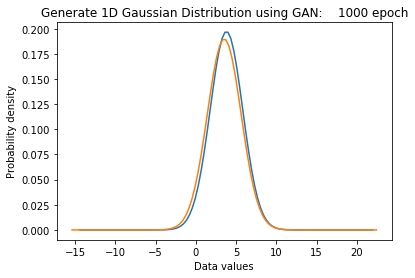

Epoch 1000: D (0.00941135548055172 real_err, -0.011482550762593746 fake_err) G (0.011088905856013298 err); Real Dist ([4.008890305384994, 2.1087881596855427]),  Fake Dist ([3.102758723385632, 2.281977113440195]) 


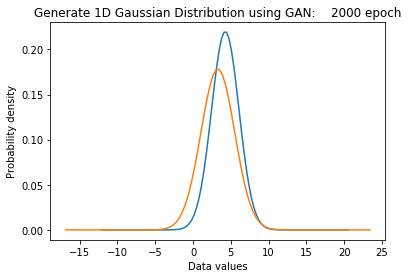

Epoch 2000: D (-0.35648244619369507 real_err, 0.18408851325511932 fake_err) G (-0.1598115712404251 err); Real Dist ([4.165144299715758, 1.8694082248698038]),  Fake Dist ([3.8292401260882616, 2.0777446490268083]) 


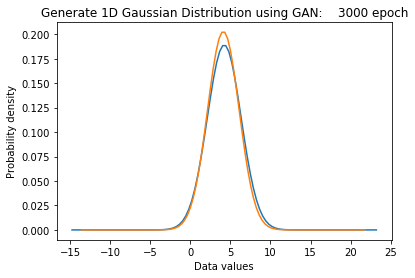

Epoch 3000: D (-0.41741180419921875 real_err, 0.10075261443853378 fake_err) G (-0.23054912686347961 err); Real Dist ([4.146851646602154, 1.817519688675421]),  Fake Dist ([3.6992360354587435, 2.0448425035941935]) 


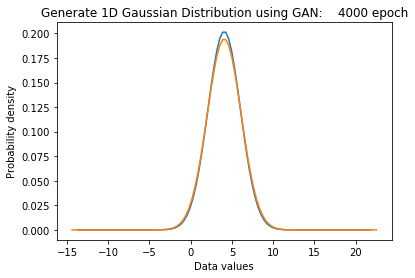

Epoch 4000: D (0.04123616963624954 real_err, -0.231153666973114 fake_err) G (0.026498058810830116 err); Real Dist ([3.7429507312178614, 1.9591925525524756]),  Fake Dist ([4.386023694574833, 1.7355794926623997]) 


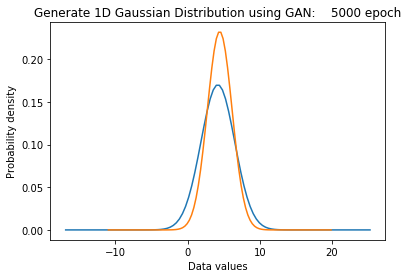

Epoch 5000: D (0.011061150580644608 real_err, -0.011000344529747963 fake_err) G (0.010978864505887032 err); Real Dist ([4.197801076471806, 1.9517398582020276]),  Fake Dist ([4.277593511343002, 1.7455134588654528]) 


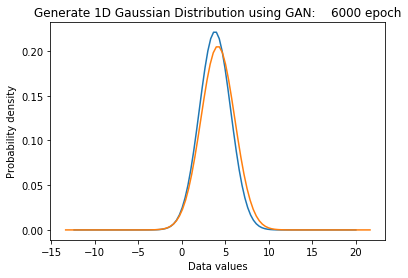

Epoch 6000: D (0.12302038818597794 real_err, -0.07282426953315735 fake_err) G (0.06500501930713654 err); Real Dist ([4.295681350529194, 1.7875214222684435]),  Fake Dist ([3.807015360072255, 2.1278808871647183]) 


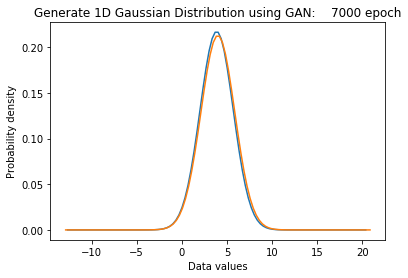

Epoch 7000: D (-0.006540825590491295 real_err, 0.014453670009970665 fake_err) G (-0.022291311994194984 err); Real Dist ([3.610860616788268, 2.144466836710847]),  Fake Dist ([3.489801816046238, 2.02704166390025]) 


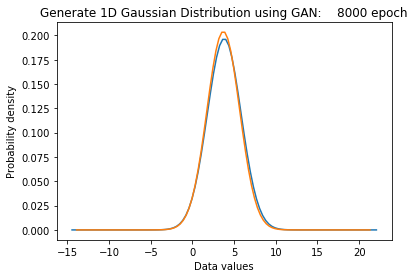

Epoch 8000: D (0.006374925374984741 real_err, -0.006189791485667229 fake_err) G (0.006575900595635176 err); Real Dist ([4.011726948581636, 1.9836908162187792]),  Fake Dist ([3.8595977430045605, 1.9962132543945155]) 


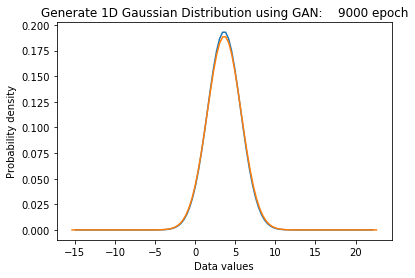

Epoch 9000: D (0.012685614638030529 real_err, -0.012677034363150597 fake_err) G (0.012917697429656982 err); Real Dist ([3.9463943852856755, 2.2006206050255908]),  Fake Dist ([3.8716350007802247, 1.9553136230261612]) 


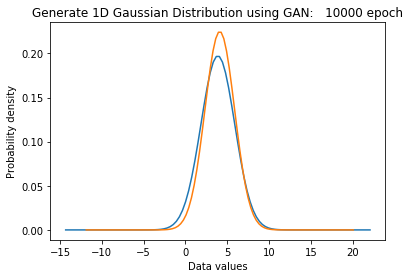

Epoch 10000: D (0.00900970958173275 real_err, -0.00897991843521595 fake_err) G (0.008799931965768337 err); Real Dist ([3.624040666371584, 2.0196245710388463]),  Fake Dist ([3.8151245161890985, 1.9595064824290416]) 


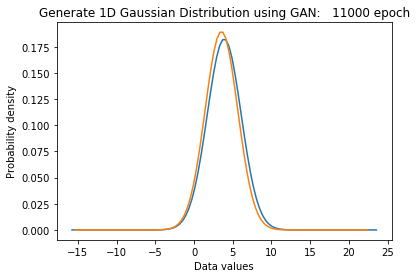

Epoch 11000: D (0.009462076239287853 real_err, -0.008101828396320343 fake_err) G (0.007839885540306568 err); Real Dist ([4.2706406380608675, 2.0924634568900973]),  Fake Dist ([3.71342066437006, 2.032336189752513]) 


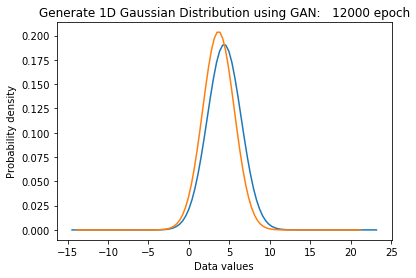

Epoch 12000: D (0.009925467893481255 real_err, -0.009919618256390095 fake_err) G (0.009951465763151646 err); Real Dist ([3.8752917218208314, 1.9858249943076172]),  Fake Dist ([3.6186655066162348, 2.102223219385217]) 


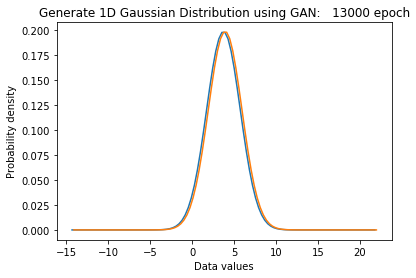

Epoch 13000: D (-0.25201085209846497 real_err, 0.16812202334403992 fake_err) G (-0.09254463762044907 err); Real Dist ([4.183417227119207, 1.948288515166057]),  Fake Dist ([3.7805829118192196, 2.0172523575057717]) 


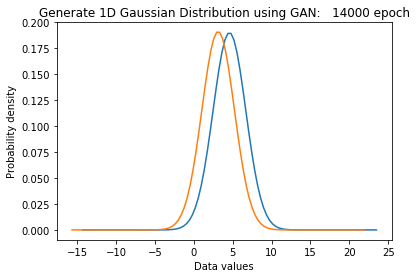

Epoch 14000: D (-0.0016584554687142372 real_err, 0.001918034628033638 fake_err) G (-0.0012941518798470497 err); Real Dist ([3.950914201438427, 2.0066063213008047]),  Fake Dist ([3.4548201111704113, 2.156270159599606]) 


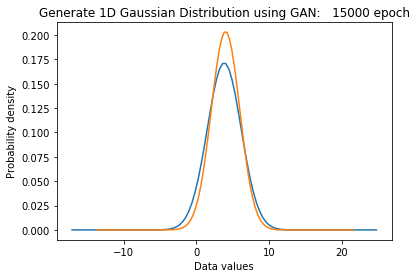

Epoch 15000: D (-0.01207633875310421 real_err, 0.07414006441831589 fake_err) G (-0.004768987186253071 err); Real Dist ([3.968152199089527, 2.2307668554049216]),  Fake Dist ([4.10141201749444, 1.8547785894391768]) 


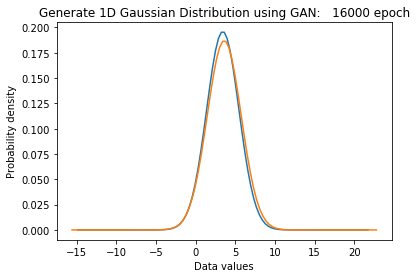

Epoch 16000: D (0.014875385910272598 real_err, -0.014955525286495686 fake_err) G (0.014912629500031471 err); Real Dist ([4.090877212136984, 2.072320015271063]),  Fake Dist ([3.73036734867841, 2.063599230159714]) 


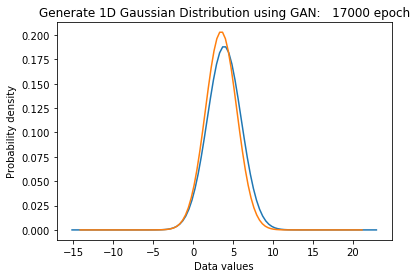

Epoch 17000: D (0.009347125887870789 real_err, -0.009206252172589302 fake_err) G (0.009194099344313145 err); Real Dist ([4.194860438555479, 2.1160472440794593]),  Fake Dist ([3.581490848213434, 2.0596713287510253]) 


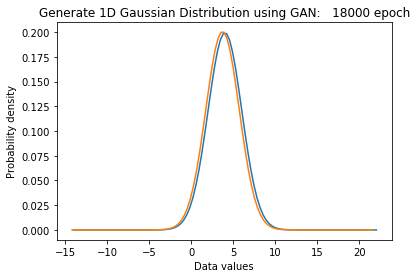

Epoch 18000: D (-0.00770840048789978 real_err, 0.009036721661686897 fake_err) G (-0.009349463507533073 err); Real Dist ([4.013755819350481, 1.94483306529571]),  Fake Dist ([3.529502940326929, 2.1664935370676575]) 


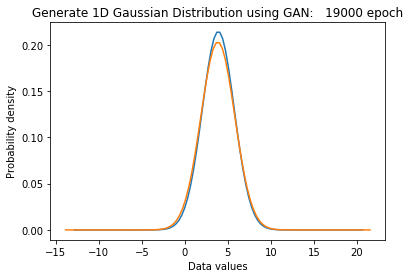

Epoch 19000: D (-0.06107573211193085 real_err, 0.038922205567359924 fake_err) G (-0.04350621998310089 err); Real Dist ([3.8391290013492108, 2.031786966783666]),  Fake Dist ([3.6446225881576537, 1.8643917736584927]) 


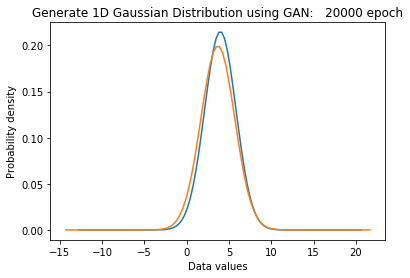

Epoch 20000: D (0.12174699455499649 real_err, 0.04506921023130417 fake_err) G (0.1074376329779625 err); Real Dist ([3.982370255291462, 2.039314761208727]),  Fake Dist ([3.6902729976177215, 1.8072413683427917]) 


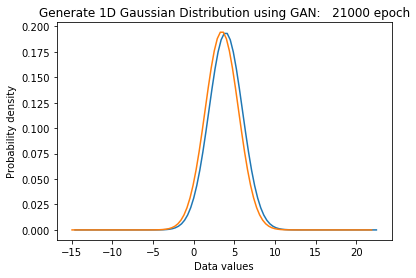

Epoch 21000: D (-0.02676541917026043 real_err, 0.026052871719002724 fake_err) G (-0.025655454024672508 err); Real Dist ([4.121917535066604, 2.214593830954846]),  Fake Dist ([3.614121043086052, 2.0961695278591708]) 


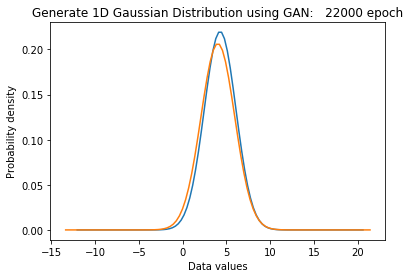

Epoch 22000: D (0.03832477331161499 real_err, 0.16931062936782837 fake_err) G (-0.05743975192308426 err); Real Dist ([3.6681717668287455, 2.1689172056657107]),  Fake Dist ([4.202570815086364, 1.7491092654928397]) 


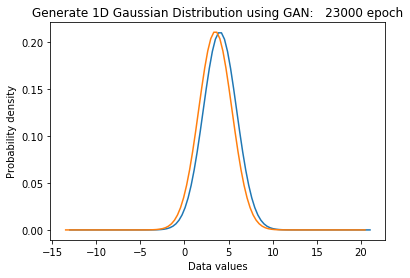

Epoch 23000: D (0.05138246715068817 real_err, -0.08035733550786972 fake_err) G (0.10351556539535522 err); Real Dist ([4.185515765547752, 2.04439040388644]),  Fake Dist ([4.0462710338830945, 1.9160203720899702]) 


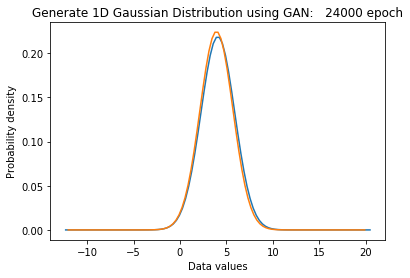

Epoch 24000: D (-0.06993170827627182 real_err, 0.059640295803546906 fake_err) G (-0.056580863893032074 err); Real Dist ([4.197546547055245, 1.9776878207062654]),  Fake Dist ([3.773166640996933, 1.8217655129022379]) 


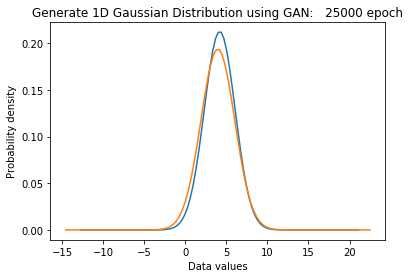

Epoch 25000: D (0.03656364232301712 real_err, -0.03785576671361923 fake_err) G (0.04224766790866852 err); Real Dist ([3.8692584253847597, 1.789230141181367]),  Fake Dist ([3.2128358656167983, 2.092119705682805]) 


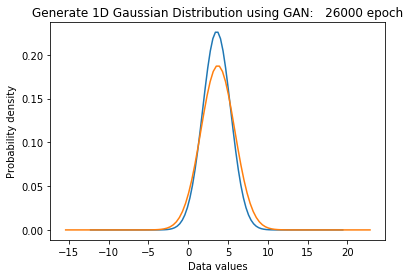

Epoch 26000: D (0.0026169121265411377 real_err, -0.0024941619485616684 fake_err) G (0.0028037033043801785 err); Real Dist ([3.848574912343174, 2.0756862787652484]),  Fake Dist ([3.9725789964199065, 2.121448769918552]) 


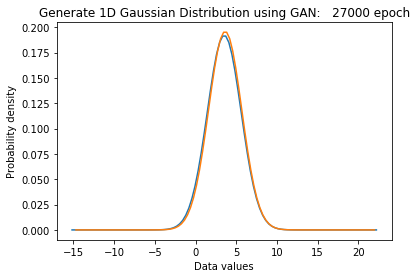

Epoch 27000: D (-0.038734070956707 real_err, -0.06832000613212585 fake_err) G (-0.06794558465480804 err); Real Dist ([3.8758609527349472, 1.9235560901345832]),  Fake Dist ([3.642807733416557, 2.089190786520687]) 


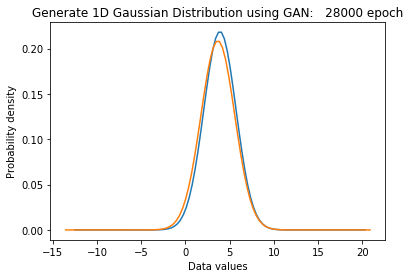

Epoch 28000: D (0.012811512686312199 real_err, -0.012379352003335953 fake_err) G (0.01236056536436081 err); Real Dist ([3.831545742750168, 1.8650670449818554]),  Fake Dist ([3.9338279378414156, 1.9401037463063353]) 


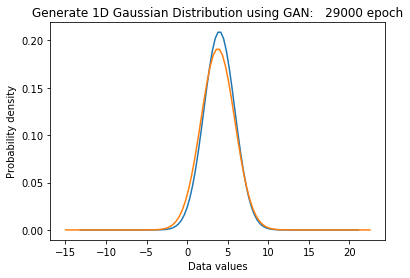

Epoch 29000: D (0.0007974924519658089 real_err, 0.007652070373296738 fake_err) G (-0.004978341981768608 err); Real Dist ([3.7854849972203373, 2.0445158964140027]),  Fake Dist ([3.7292786705493928, 2.063067791910061]) 


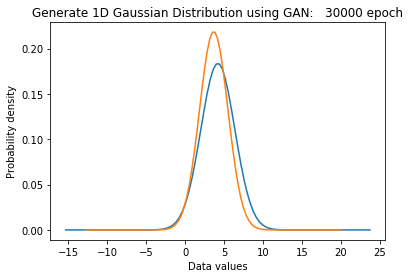

Epoch 30000: D (-0.15899376571178436 real_err, 0.14266176521778107 fake_err) G (-0.16911816596984863 err); Real Dist ([3.9025733549147845, 1.8398873547652905]),  Fake Dist ([4.154165484905243, 1.9406837336526512]) 


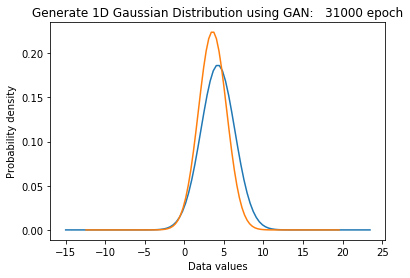

Epoch 31000: D (0.07137177884578705 real_err, -0.07777880132198334 fake_err) G (0.03592907637357712 err); Real Dist ([3.8389812913537025, 1.922086230729568]),  Fake Dist ([3.6817701590061187, 1.8394429843794855]) 


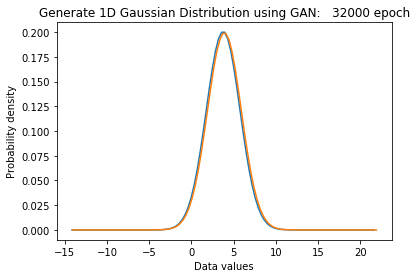

Epoch 32000: D (0.005250236019492149 real_err, -0.0052376920357346535 fake_err) G (0.005306546576321125 err); Real Dist ([3.61845808506012, 2.0659475256987454]),  Fake Dist ([3.6524273586273193, 2.0596864677047457]) 


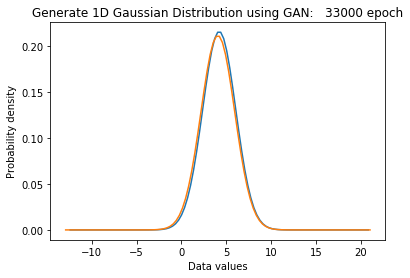

Epoch 33000: D (0.012874864973127842 real_err, -0.013286817818880081 fake_err) G (0.01644246280193329 err); Real Dist ([4.00455981194973, 1.9837885645379127]),  Fake Dist ([4.105690273046494, 1.8711941786688702]) 


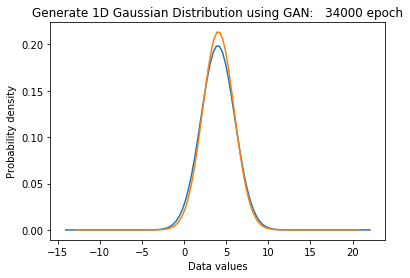

Epoch 34000: D (0.10120587795972824 real_err, -0.04578127712011337 fake_err) G (-0.016077710315585136 err); Real Dist ([3.4668836921453474, 2.135143627367412]),  Fake Dist ([3.6676776540279388, 2.007331766218623]) 


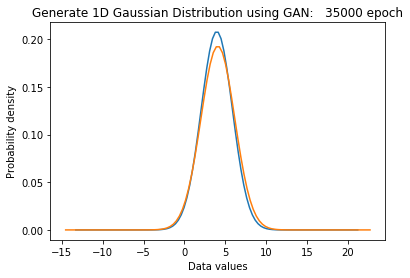

Epoch 35000: D (0.010246806778013706 real_err, -0.010236718691885471 fake_err) G (0.0101612014696002 err); Real Dist ([4.308196531534195, 1.9905770419948814]),  Fake Dist ([3.570370983481407, 1.976680970768557]) 


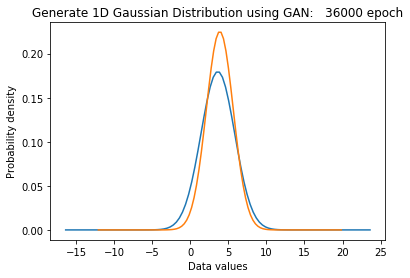

Epoch 36000: D (0.004264037124812603 real_err, -0.0030971989035606384 fake_err) G (0.0033106026239693165 err); Real Dist ([4.118841750174761, 2.2736478999906238]),  Fake Dist ([4.286701049804687, 1.755712495515598]) 


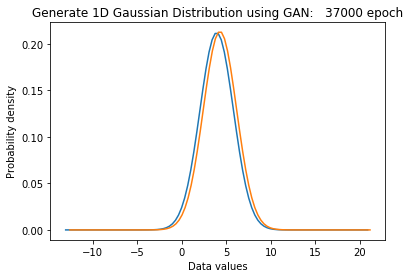

Epoch 37000: D (-0.07976122200489044 real_err, 0.07870127260684967 fake_err) G (-0.08207545429468155 err); Real Dist ([4.10590089045465, 1.8716631192283313]),  Fake Dist ([4.345544345378876, 1.9405830676387563]) 


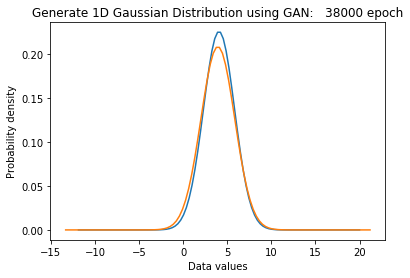

Epoch 38000: D (0.10761385411024094 real_err, -0.06518252938985825 fake_err) G (0.049498312175273895 err); Real Dist ([3.753139107003808, 1.8598999409078103]),  Fake Dist ([3.845048679113388, 1.9060067777397436]) 


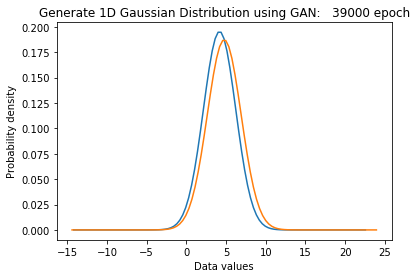

Epoch 39000: D (0.06817597895860672 real_err, -0.07398055493831635 fake_err) G (0.08295288681983948 err); Real Dist ([3.5618703240156173, 1.924880337084282]),  Fake Dist ([4.567668331861496, 2.0462501594434603]) 


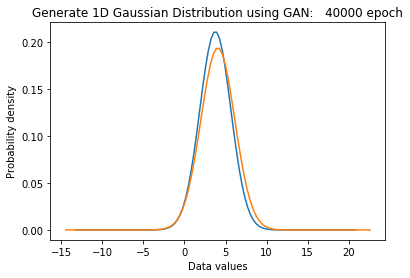

Epoch 40000: D (-0.10806330293416977 real_err, 0.1245741918683052 fake_err) G (-0.1041615828871727 err); Real Dist ([3.859157063961029, 2.120061214058371]),  Fake Dist ([4.302401564121246, 1.9157916169714218]) 


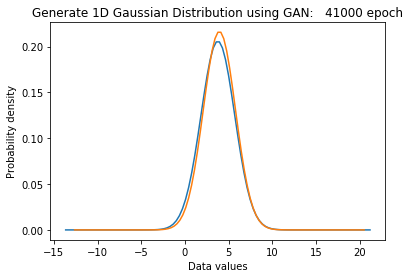

Epoch 41000: D (-0.05079009383916855 real_err, 0.027168231084942818 fake_err) G (-0.03945250064134598 err); Real Dist ([3.817034664750099, 1.950399530016747]),  Fake Dist ([4.092028994560241, 1.8012714485755414]) 


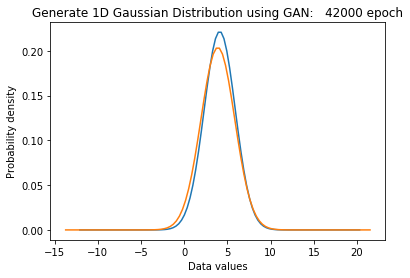

Epoch 42000: D (0.0434243381023407 real_err, -0.05213887244462967 fake_err) G (-0.0009403638541698456 err); Real Dist ([4.227707142233848, 1.6839610528045355]),  Fake Dist ([4.117397880554199, 1.9794510934062775]) 


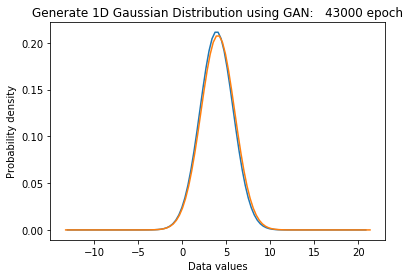

Epoch 43000: D (0.03788445144891739 real_err, -0.0023210453800857067 fake_err) G (0.03423343598842621 err); Real Dist ([3.869105630069971, 2.122983013694925]),  Fake Dist ([3.9654024124145506, 1.9077568782424028]) 


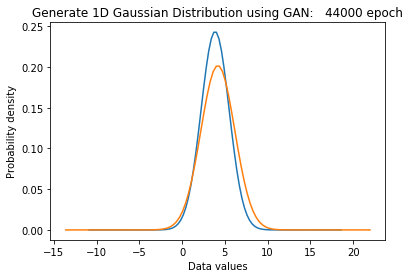

Epoch 44000: D (0.03872121870517731 real_err, -0.02028517797589302 fake_err) G (0.07165791839361191 err); Real Dist ([3.9013690200448035, 1.865917870420635]),  Fake Dist ([4.119048537611961, 2.050029207141583]) 


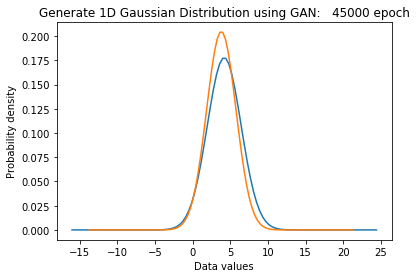

Epoch 45000: D (0.007300983648747206 real_err, 0.0652017816901207 fake_err) G (-0.08310407400131226 err); Real Dist ([3.9193950751423836, 1.7434583904866974]),  Fake Dist ([3.857094150185585, 1.9532690358636497]) 


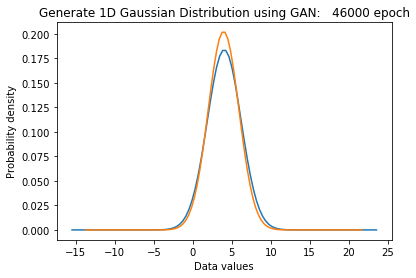

Epoch 46000: D (0.045387715101242065 real_err, -0.0831894502043724 fake_err) G (0.09377703815698624 err); Real Dist ([4.083639441747218, 2.3058216340614677]),  Fake Dist ([3.889954546689987, 1.8827438597434902]) 


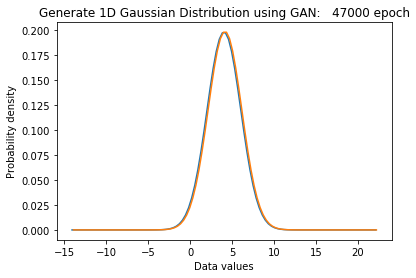

Epoch 47000: D (-0.05363013595342636 real_err, -0.044456154108047485 fake_err) G (-0.009299775585532188 err); Real Dist ([3.92957640260458, 2.1033648974430745]),  Fake Dist ([3.8004304283857344, 1.94847867825823]) 


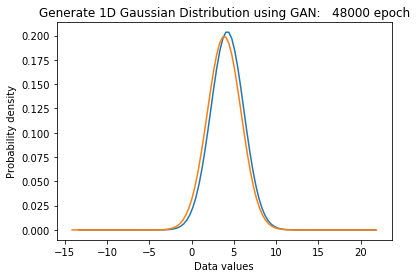

Epoch 48000: D (-0.03302823752164841 real_err, -0.08615919202566147 fake_err) G (0.03263726085424423 err); Real Dist ([3.9919309200719, 1.9307461218018618]),  Fake Dist ([4.281184241771698, 2.124014282855617]) 


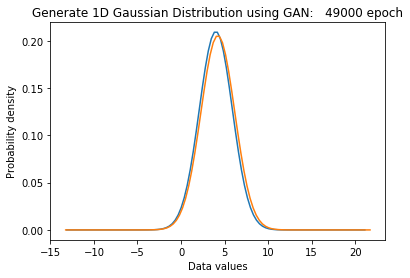

Epoch 49000: D (0.03206154704093933 real_err, -0.07191774994134903 fake_err) G (-0.04570474475622177 err); Real Dist ([3.489966408610344, 1.7083182459014807]),  Fake Dist ([3.929159885644913, 1.9440644039583794]) 


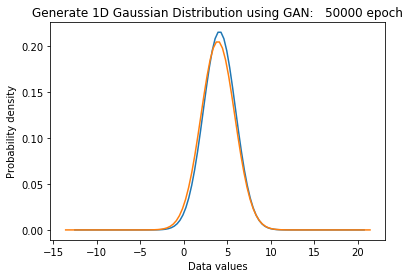

In [45]:
import time
start = time.time()
train()
stop = time.time()
duration = stop - start

In [50]:
duration

557.3371970653534